An example of exploratory data analysis on data collected from [Etcheverry Roof](https://radwatch.berkeley.edu/dosenet/downloads).
Here is a link to download the [data](https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof.csv).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import bokeh
import numpy as np
import sklearn
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import HoverTool
from bokeh.plotting import figure
output_notebook()
from scipy.stats import pearsonr
import scipy
from math import isnan
import seaborn as sns  # makes matplotlib beautiful

Loading BokehJS ...

In [2]:
etch_roof_pg_url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof.csv'  # pocket geiger data
data_pg = pd.read_csv(etch_roof_pg_url)
data_pg.head()

,deviceTime_utc,deviceTime_local,deviceTime_unix,cpm,cpmError
0,2018-06-22 07:25:54+00:00,2018-06-22 00:25:54-07:00,1529652354,2.4,0.692820
1,2018-06-22 07:20:54+00:00,2018-06-22 00:20:54-07:00,1529652054,3.2,0.800000
2,2018-06-22 07:16:00+00:00,2018-06-22 00:16:00-07:00,1529651760,1.4,0.529150
3,2018-06-22 07:10:54+00:00,2018-06-22 00:10:54-07:00,1529651454,2.2,0.663325
4,2018-06-22 07:05:54+00:00,2018-06-22 00:05:54-07:00,1529651154,3.0,0.774597


In [3]:
etch_roof_co2_url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof_adc.csv'  # CO2 data
data_co2 = pd.read_csv(etch_roof_co2_url)
data_co2.head()

,deviceTime_utc,deviceTime_local,deviceTime_unix,co2_ppm,noise
0,2018-06-22 09:40:49+00:00,2018-06-22 02:40:49-07:00,1529660449,544.80,3.13
1,2018-06-22 09:25:49+00:00,2018-06-22 02:25:49-07:00,1529659549,554.96,3.11
2,2018-06-22 08:50:49+00:00,2018-06-22 01:50:49-07:00,1529657449,564.75,3.08
3,2018-06-22 08:45:49+00:00,2018-06-22 01:45:49-07:00,1529657149,565.57,3.11
4,2018-06-22 08:40:54+00:00,2018-06-22 01:40:54-07:00,1529656854,574.06,3.14


In [4]:
# weather data
etch_roof_weather_url = 'https://radwatch.berkeley.edu/sites/default/files/dosenet/etch_roof_weather.csv'
data_weather = pd.read_csv(etch_roof_weather_url)
data_weather.head()

,deviceTime_utc,deviceTime_local,deviceTime_unix,temperature,pressure,humidity
0,2018-06-22 09:40:49+00:00,2018-06-22 02:40:49-07:00,1529660449,18.25,1000.76,61.59
1,2018-06-22 09:25:49+00:00,2018-06-22 02:25:49-07:00,1529659549,18.11,1000.90,61.42
2,2018-06-22 08:50:49+00:00,2018-06-22 01:50:49-07:00,1529657449,18.03,1000.77,61.45
3,2018-06-22 08:46:03+00:00,2018-06-22 01:46:03-07:00,1529657163,18.05,1000.81,61.68
4,2018-06-22 08:45:49+00:00,2018-06-22 01:45:49-07:00,1529657149,18.05,1000.81,61.68


In [5]:
data_weather['datetime'] = pd.to_datetime(data_weather['deviceTime_utc'])

p = figure(plot_width=960, plot_height=480, title='Etcheverry Rooftop Temperature', x_axis_type='datetime')

p.line(data_weather['datetime'], data_weather['temperature'], line_width=2)
p.add_tools(HoverTool(tooltips=[('Time', '$x'), ('Temp', '$y')]))

p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Temperature'

show(p)

In [6]:
def near_time_search(list_, time, delta):
    """Binary search algorithm to find the datetime closest to 
    `time` within the list/array `list_`.
    
    :param list_:       SORTED list of timestamps
    :param time:        timestamp being searched for
    :return:            Nan if no timestamp found within `delta` of `time`
                        timestamp closest to `time`
    
    >>> near_time_search([1, 2, 3], 2, 1)
    2
    >>> near_time_search([3.4, 3.8, 4, 6], 4.1, 0.3)
    4
    >>> near_time_search([3.4, 3.8, 4, 6], 4.1, 0.05)
    nan
    >>> near_time_search([3.4, 3.8, 4, 6], 10, 3.5)
    nan
    >>> near_time_search([3.4, 3.8, 4, 6], 10, 7)  # should return `6`, not `4`
    6
    >>> near_time_search([3.4, 3.8, 4, 6], 5, 7)  # should return `6`, not `4`
    6
    >>> near_time_search(np.ones((1_000_000,)), 0.8, 0.2)
    1.0
    """
    lo = 0
    hi = len(list_)
    mid = (lo + hi) // 2
    
    while lo < mid < hi:
        if list_[mid] < time:
            lo = mid + 1
        elif list_[mid] > time:
            hi = mid - 1
        else:
            return list_[mid]
        mid = (lo + hi) // 2
    
    if (mid < hi) and (abs(list_[mid] - time) <= delta):
        return list_[mid]
    elif abs(list_[mid - 1] - time) <= delta:
        return list_[mid - 1]
    return float('nan')

def nts_with_arr(list_, time_arr, delta):
    result = []
    for elem in time_arr:
#         print(elem)
        result.append(near_time_search(list_, elem, delta))
    return result

# run doctests to see whether the function behaves as it should
import doctest
doctest.testmod()

TestResults(failed=0, attempted=7)

### Correlations Between $temperature$ and $CO_2$ Concentration

First, we need to find corresponding $temperature$ and $CO_2$ observations based on the timestamps of the obsevations. We will use the `near_time_search` function for this.

In [7]:
# the data needs to be sorted in ascending order according to time (it is
# sorted in descending order)
data_co2.sort_values('deviceTime_unix', inplace=True)
data_weather.sort_values('deviceTime_unix', inplace=True)

co2_temp_df = pd.DataFrame(columns=['co2_time', 'temp_time', 'co2', 'temp'])
co2_temp_df['co2_time'] = data_co2['deviceTime_unix']
co2_temp_df['temp_time'] = nts_with_arr(data_weather['deviceTime_unix'].tolist(),
                                        co2_temp_df['co2_time'].tolist(),
                                        delta=300)

time_diff = (co2_temp_df['temp_time'] - co2_temp_df['co2_time'])
print(time_diff)

57049      0.0
57048   -300.0
57047      0.0
57046      0.0
57045   -300.0
57044      0.0
57043      0.0
57042   -300.0
57041      0.0
57040   -300.0
57039      0.0
57038   -300.0
57037      0.0
57036      0.0
57035   -300.0
57034      0.0
57033   -300.0
57032      0.0
57031   -300.0
57030      0.0
57029      0.0
57028   -300.0
57027      0.0
57026   -300.0
57025      0.0
57024   -300.0
57023      0.0
57022      0.0
57021   -300.0
57020      0.0
         ...  
29      -300.0
28         0.0
27      -300.0
26         NaN
25      -294.0
24         0.0
23         5.0
22      -290.0
21         0.0
20         NaN
19         0.0
18      -300.0
17         0.0
16         1.0
15      -293.0
14         0.0
13         NaN
12         0.0
11      -300.0
10         0.0
9          0.0
8       -300.0
7          0.0
6       -300.0
5          NaN
4       -299.0
3          0.0
2          0.0
1          NaN
0          0.0
Length: 57050, dtype: float64


Interestingly, there are many instances where the $temperature$ and $CO_2$ timestamps are different by about 300 seconds. These probably correspond to instances where one of the sensors did not make a measurement, so we would want these to be `NaN` and thus excluded from our calculation of correlation.

In [8]:
# let's see how many differences are +-300 or NaN
time_diff.value_counts(dropna=False)

 0.0      28285
-300.0    20511
NaN        3652
-299.0     1779
 1.0        632
-298.0      529
-294.0      326
-5.0        244
 2.0        187
-6.0        150
-293.0      107
-1.0         99
 6.0         92
 295.0       65
 294.0       51
-297.0       28
 4.0         25
-2.0         23
 7.0         21
-296.0       17
 298.0       15
-295.0       14
 3.0         12
 299.0       12
-182.0       11
-292.0       10
-291.0       10
 300.0        9
-3.0          9
-290.0        8
          ...  
-285.0        1
-283.0        1
-43.0         1
-106.0        1
-98.0         1
-255.0        1
-40.0         1
 281.0        1
 9.0          1
 286.0        1
-234.0        1
 12.0         1
-110.0        1
-271.0        1
-62.0         1
-261.0        1
-272.0        1
 269.0        1
-275.0        1
-17.0         1
-20.0         1
-251.0        1
 276.0        1
-131.0        1
-14.0         1
-18.0         1
-33.0         1
-91.0         1
-48.0         1
 17.0         1
Length: 90, dtype: int64

We don't want to consider elements with time difference more than a few seconds, because those will spuriously lead us to count the same observation twice (think why!). Pandas lets us easily remove rows with duplicate values using the `DataFrame.drop_duplicates` function.

In [9]:
co2_temp_df['temp_time'] = nts_with_arr(data_weather['deviceTime_unix'].tolist(),
                                        co2_temp_df['co2_time'].tolist(),
                                        delta=300)  # <-- delta=30 instead of 300
# print("==========================================================================")
# print("Let's see how many repeated timestamps we have with `delta` of 300 seconds.")
# print("--------------------------------------------------------------------------")
# print(co2_temp_df['temp_time'].value_counts(dropna=False))

# co2_temp_df['pg_time'] = nts_with_arr(data_pg['deviceTime_unix'].tolist(),
#                                       co2_temp_df['co2_time'].tolist(),
#                                       delta=1500)

# Now let's remove the duplicates
co2_temp_df = co2_temp_df.drop_duplicates(subset=['temp_time'], keep='first')
print(co2_temp_df)

         co2_time     temp_time  co2 temp
57049  1510944049  1.510944e+09  NaN  NaN
57047  1510944649  1.510945e+09  NaN  NaN
57046  1510944949  1.510945e+09  NaN  NaN
57044  1510945549  1.510946e+09  NaN  NaN
57043  1510945849  1.510946e+09  NaN  NaN
57041  1510946449  1.510946e+09  NaN  NaN
57039  1510947049  1.510947e+09  NaN  NaN
57037  1510947649  1.510948e+09  NaN  NaN
57036  1510947949  1.510948e+09  NaN  NaN
57034  1510948549  1.510949e+09  NaN  NaN
57032  1510949149  1.510949e+09  NaN  NaN
57030  1510949749  1.510950e+09  NaN  NaN
57029  1510950049  1.510950e+09  NaN  NaN
57027  1510950649  1.510951e+09  NaN  NaN
57025  1510951249  1.510951e+09  NaN  NaN
57023  1510951849  1.510952e+09  NaN  NaN
57022  1510952149  1.510952e+09  NaN  NaN
57020  1510952749  1.510953e+09  NaN  NaN
57018  1510953349  1.510953e+09  NaN  NaN
57016  1510953949  1.510954e+09  NaN  NaN
57015  1510954249  1.510954e+09  NaN  NaN
57013  1510954849  1.510955e+09  NaN  NaN
57011  1510955449  1.510955e+09  N

Now let's fill in the $temperature$ and $CO_2$ concentration values.

In [10]:
# first let's remove rows where `temp_time` is `NaN`
# make the entire row `NaN` if `temp_time` is `NaN`
for idx, _, temp_time, _, _ in co2_temp_df.itertuples():
    if isnan(temp_time):
        co2_temp_df.loc[idx, 'co2_time'] = float('nan')
# drop rows that are filled with `NaN`s only
co2_temp_df = co2_temp_df.dropna(how='all')

In [11]:
# now let's fill in the values
for idx, _, _, _, _ in co2_temp_df.itertuples():
    try:
        co2_temp_df.loc[idx, 'co2'] = data_co2.loc[idx, 'co2_ppm']
        co2_temp_df.loc[idx, 'temp'] = data_weather.loc[idx, 'temperature']
    except KeyError as ke:
#         print('Skipped index %d' % idx)
        continue
co2_temp_df

,co2_time,temp_time,co2,temp
57049,1.510944e+09,1.510944e+09,544.68,NaN
57047,1.510945e+09,1.510945e+09,572.51,NaN
57046,1.510945e+09,1.510945e+09,563.72,NaN
57044,1.510946e+09,1.510946e+09,569.44,NaN
57043,1.510946e+09,1.510946e+09,566.09,NaN
57041,1.510946e+09,1.510946e+09,565.27,NaN
57039,1.510947e+09,1.510947e+09,561.96,NaN
57037,1.510948e+09,1.510948e+09,569.87,NaN
57036,1.510948e+09,1.510948e+09,564.58,NaN
57034,1.510949e+09,1.510949e+09,568.21,NaN


Let's clean up `NaN`s one last time before we find the ~correlations~!!!

In [12]:
co2_temp_df = co2_temp_df.dropna()
co2_temp_df

,co2_time,temp_time,co2,temp
56836,1.511000e+09,1.511000e+09,471.72,17.57
56835,1.511000e+09,1.511000e+09,470,17.04
56833,1.511001e+09,1.511001e+09,472.03,16.39
56831,1.511001e+09,1.511001e+09,474.86,16.4
56829,1.511002e+09,1.511002e+09,474.91,16.74
56828,1.511002e+09,1.511002e+09,472.2,16.92
56826,1.511003e+09,1.511003e+09,465.32,17.24
56824,1.511003e+09,1.511003e+09,471.89,16.91
56822,1.511004e+09,1.511004e+09,467.57,17.19
56821,1.511004e+09,1.511004e+09,461.21,17.41


Now let's find the correlation between $temperature$ and $CO_2$ concentration (finally!!!) using the handy `scipy.stats.pearsonr` function, which also returns the two-tailed p-value for the two series of data being analyzed.

In [13]:
r_value, p_value = pearsonr(co2_temp_df['temp'], co2_temp_df['co2'])
print(f"Pearson's correlation coefficient: {r_value}")
print(f"Two-tailed p-value: {p_value}")

Pearson's correlation coefficient: 0.04381132982269797
Two-tailed p-value: 8.459725508262324e-15


A correlation coefficient $<0.30$ suggests there is no correlation between temperature and $CO_2$ concentration. Let's verify that graphically.

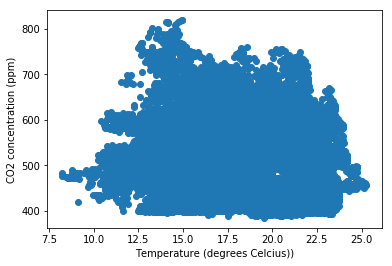

In [14]:
plt.scatter(co2_temp_df['temp'], co2_temp_df['co2'])
plt.xlabel("Temperature (degrees Celcius))")
plt.ylabel("CO2 concentration (ppm)")
plt.show()

Clearly, there is no correlation between temperature and $CO_2$ concentration.

## More Correlations
Let's look for correlated variables a little more systematically by making a correlation matrix. Pandas lets us do that easily using the `DataFrame.corr` function.

In [15]:
co2_temp_df = co2_temp_df.assign(humidity=pd.Series(np.full(co2_temp_df.shape[0], float('nan'))).values)
co2_temp_df = co2_temp_df.assign(pressure=pd.Series(np.full(co2_temp_df.shape[0], float('nan'))).values)

In [ ]:
for idx, _, _, _, _, _, _ in co2_temp_df.itertuples():
    try:
        co2_temp_df.loc[idx, 'pressure'] = data_weather.loc[idx, 'humidity']
        co2_temp_df.loc[idx, 'humidity'] = data_weather.loc[idx, 'pressure']
    except KeyError as ke:
        print('Skipped index %d' % idx)
        continue

In [ ]:
co2_temp_df.dropna()
co2_temp_df['temp'] = co2_temp_df['temp'].astype(float)
co2_temp_df['co2'] = co2_temp_df['co2'].astype(float)

correlation_matrix = co2_temp_df.corr()

with sns.axes_style("dark"):
    sns.heatmap(data=correlation_matrix.loc['co2': 'pressure', 'co2': 'pressure'],
                vmin=-1.0, vmax=1.0, annot=True, cbar=True, linecolor='#000000FF', linewidth='0.1')

Okay, so there is weak correlation ($0.7\geq|r|\geq0.3$) between $humidity$ and $pressure$, and very weak correlation ($r<0.3$) for the rest.

## Radiation
Now, finally, let's see if weather indicators have any correlation with the background radiation level.

In [ ]:
co2_temp_df = co2_temp_df.assign(radiation=pd.Series(np.full(co2_temp_df.shape[0], float('nan'))).values)

# co2_temp_df['pg_time'] = nts_with_arr(co2_temp_df['co2_time'].astype(int).tolist(),
#                                       data_pg['deviceTime_unix'].tolist(),
#                                       delta=300)

pg_tt = pd.Series(nts_with_arr(co2_temp_df['co2_time'].astype(int).tolist(),
                     data_pg['deviceTime_unix'].tolist(),
                     delta=300))

# time_diff = (data_pg['deviceTime_unix'] - co2_temp_df['co2_time'])
pg_tt.dropna(inplace=True)
pg_tt.drop_duplicates(inplace=True)

co2_temp_df['pg_time'] = nts_with_arr(pg_tt.tolist(),
                                      co2_temp_df['co2_time'].astype(int).tolist(),
                                      delta=300)

print(pg_tt.value_counts(dropna=False))

In [ ]:
data_pg['deviceTime_unix']

In [ ]:
co2_temp_df['pg_time'].value_counts(dropna=False)

In [ ]:
# for idx, c02_time, _, _, _, _, _, _ in co2_temp_df.itertuples():
#     try:
#         co2_temp_df.loc[idx, 'radiation'] = data_pg.loc[near_time_search(list_=), 'humidity']
#     except KeyError as ke:
#         print('Skipped index %d' % idx)
#         continue